# Game Classification Model

In [488]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics

game_data = pd.read_csv('game_data.csv') #names = col_names if not in CSV
# game_data.head() # See the first 5 rows

### clean and filter data

In [489]:
# bgg_games = bgg_data[bgg_data['type'] == 'boardgame'] # no expansions
# bgg_games = game_data[game_data['year'] > 1980]
bgg_games = game_data[game_data['year'] > 1990]
bgg_games = bgg_games[bgg_games['maxplayers'] <= 30]
bgg_games = bgg_games[bgg_games['minplaytime'] <= 120] # 120 - 90th percentile
bgg_games = bgg_games[bgg_games['maxplaytime'] <= 720]
bgg_games = bgg_games[bgg_games['minage'] <= 18]

In [490]:
# cell for data exploration
# bgg_games.columns

### select cells potentially relevant to categories

In [491]:
dtc_test = bgg_games[['type', 'year', 'minplayers', 'maxplayers', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'users_rated', 'avg_rating',
       'bay_rating', 'owners', 'traders', 'wanters', 'wishers',
       'total_comments', 'total_weights', 'complexity', 'categories',
       'mechanics']]

#### convert mechanics and categories into lists with values

In [492]:
dtc_test['categories'] = dtc_test['categories'].apply(lambda x: x.strip('][').split(', ') )
dtc_test['mechanics'] = dtc_test['mechanics'].apply(lambda x: x.strip('][').split(', ') )

In [493]:
def split_data_frame_list(df, target_column, output_type=str):
    ''' 
    Accepts a column with list values and splits into several rows.

    df: dataframe to split
    target_column: the column containing the values to split
    output_type: type of all outputs
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def split_list_to_rows(row):
        split_row = row[target_column]
        if isinstance(split_row, list):
          for s in split_row:
              new_row = row.to_dict()
              new_row[target_column] = output_type(s)
              row_accumulator.append(new_row)
        else:
          new_row = row.to_dict()
          new_row[target_column] = output_type(split_row)
          row_accumulator.append(new_row)
  
    df.apply(split_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
  
    return new_df

#### split lists into multiple rows for decision tree

In [494]:
dtc_test = split_data_frame_list(dtc_test, 'categories')
dtc_test = split_data_frame_list(dtc_test, 'mechanics')

#### get all desired cols and apply one-hot fix to categorical features

In [495]:
# for filtering cols
desired_cols = ['minplayers','maxplayers','minplaytime', 'maxplaytime', 'avg_rating', 'bay_rating', 'complexity', 'categories', 'mechanics']
# desired_cols = ['type', 'year', 'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'users_rated', 'avg_rating', 'bay_rating', 'owners', 'traders', 'wanters', 'wishers', 'total_comments', 'total_weights', 'complexity', 'categories', 'mechanics']

target_col = 'catergories'

# make dummies and attach to frame for tree model
tree_frame = dtc_test[desired_cols]
# mech_dummies = pd.get_dummies(tree_frame['mechanics'], prefix='mech', drop_first=True)
# tree_frame = pd.concat([tree_frame, mech_dummies], axis=1)

# tree_frame.head()

#### filter out categorical columns for tree fitting

In [496]:
# list of just desired features, now including one-hot cols and remove categorical cols
features = list(tree_frame.columns)

# remove either categorical cols or all cols
features.remove('mechanics')
features.remove('categories')

# for col in desired_cols:
#     features.remove(col)
# print(features)

### Divide the data set
#### split data into training portions

In [497]:
# filtered features with one-hot fixes for categorical columns
X = tree_frame[features]

# target variable
y = tree_frame.categories

# Split method, 0.3 == 30% of data saved for testing, choosen randomly from set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Train the model in just three simple steps
see why data scientists everywhere hate him

In [498]:
# Create Decision Tree classifer object
# arguments for pruning

# 0.13976 w/ dummies + others
# dtc = DecisionTreeClassifier(criterion="entropy", splitter = 'best', max_depth=6)
# 0.14862 w/ no mechanics
# dtc = DecisionTreeClassifier(criterion="entropy", splitter = 'best', max_depth=7)
dtc = DecisionTreeClassifier(criterion="entropy", splitter = 'best', max_depth=10)

# Train Decision Tree Classifer
dtc = dtc.fit(X_train,y_train)

# predictions by model for y
y_pred = dtc.predict(X_test)

# compare to y_test to get accuracy
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.1556158328310227


### Visualize training tree model - DOWNGRADE SKLEARN!!

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.089127 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.089127 to fit



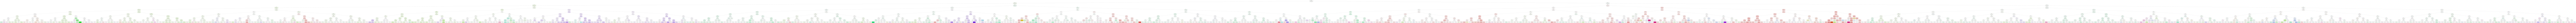

In [499]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
# number of unique values in target col
class_names = list(tree_frame.categories.unique())

# use trained decision tree model, feature columns, and clases in target col
export_graphviz(dtc, out_file = dot_data, filled=True, rounded=True, special_characters=True,
                feature_names = features,
                class_names = class_names)

# creates image and then displays in Jupyter
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('game_classes.png')
Image(graph.create_png())